### Nonlinear Option Pricing (MATHGR5400), Columbia University, Spring 2020
# Homework IV

### Due Date: 5:00 PM Friday, April 17, 2020
You should turn in the notebook at Columbia CourseWorks website

Please comment your code properly.

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly in a reasonable time frame, and then save the notebook.

<h3 style="color:deepskyblue">Uncertain Volatility Model 1D</h3>

The price of a vanilla payoff $g(X_T)$ on a single asset $X_t$ in the uncertain volatility model satisfies the
one dimensional Black-Scholes-Barenblatt (BSB) PDE
\begin{align*}
\partial_tu(t,x)+\frac{1}{2}x^2\partial_x^2u(t,x)\Sigma\left(\partial_x^2u(t,x)\right)^2&=0\\
u(T,x)&=g(x)
\end{align*}
where
\begin{equation*}
\Sigma(\Gamma)=\left\{\begin{array}\,
\underline{\sigma} & \text{ if }\Gamma<0\\ \overline{\sigma} & \text{ if }\Gamma\geq 0\end{array}\right.
\end{equation*}
For the sake of simplicity, we assume zero interest rate and zero dividend and repo.

The BSB PDE is a fully nonlinear second order parabolic PDE which has a stochastic representation by second-oder BSDE. We are <b>free to choose</b> the diffusion for the underlying asset $X$; we pick a lognormal dynamics with some constant volatility $\hat\sigma$,

$$dX_t=\hat{\sigma} X_tdW_t$$

Two numerical schemes to solve 2-BSDEs are presented below. We first divide $(0, T)$ into $n$ subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$ and set $\Delta t_i=t_i-t_{i-1}$ and $\Delta W_{t_i} = W_{t_i} - W_{t_{i-1}}$.

<b>Scheme 1</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Z_{t_n}&=g'\left(X_{t_n}\right)\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
Z_{t_{i-1}}&=\frac{1}{\Delta t_i\hat{\sigma} X_{t_{i-1}}}\mathbb{E}_{i-1}\left[Y_{t_i}\Delta W_{t_i}\right]\\
\Gamma_{t_{i-1}}&=\frac{1}{\Delta t_i\hat{\sigma} X_{t_{i-1}}}\mathbb{E}_{i-1}\left[Z_{t_i}\Delta W_{t_i}\right]
\end{align*}

In the second scheme, we introduce explicitly the Malliavin weight for the log-normal diffusion with volatility $\hat{\sigma}$, so that $\Gamma$ can be estimated directly from $Y$ without computing $Z$ in the intermediate step. In particular, there is no need to compute the final condition $Z_{t_n}=g'\left(X_{t_n}\right)$. This could be useful to handle non-smooth payoffs.

<b>Scheme 2</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
\Gamma_{t_{i-1}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[Y_{t_i}\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]
\end{align*}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d

In [2]:
def blackscholes_mc(S=100, vol=0.2, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=100, return_params=False):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    S: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.
    ts: array_like
        The time steps of the simualtion
    npaths: int
        the number of paths to simulate

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    nsteps = len(ts) - 1
    ts = np.asfarray(ts)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=np.float),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r-q)*ts)
    if return_params:
        return paths, W
    else:
        return paths

In [3]:
def pwlinear_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
    #return a function to get a list
    #first column: 1, second column: x-xkonts[0], next 8 columns: max(x-xknots[i],0)
    fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: x-xknots[0]] 
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))]) #take max to make piecewise
    return fs

def pwlinear_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlinear_basis(xknots)
    A = np.vstack([f(xdata) for f in fs]).T
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]  #solve for A*ps=ydata
    return ps, fs

<b style="color:darkorange">Question 1.</b> Consider pricing the call spread $\frac{100}{K_2-K_1}\left(\left(X_T-K_1\right)^+-\left(X_T-K_2\right)^+\right)$ in the uncertain volatility model, where

\begin{equation*}
\underline{\sigma}=0.1,\quad\overline{\sigma}=0.2,\quad X_0=100,\quad T=1, \quad K_1 = 90, \quad K_2 = 110
\end{equation*}

For your reference, the true price (from PDE) is $56.0$.

<b>(a).</b> Implement Scheme 1 with 12 time steps $(\Delta t_1=1/12)$ and 5000 paths. After you obtain estimates of $x\mapsto\Gamma\left(t_i, x\right)$ at each discretization time $t_i$, re-simulate a new set of independent paths following the process $dX_t = \Sigma(\Gamma(t,X_t))X_tdW_t$ to price the call spread, using more time steps (say, 400 $(\Delta t_2=1/400)$), and more paths (say, 50,000).

<ul>
<li> Experiment with different values of $\hat\sigma$, and smaller $\Delta t_1$. Comment on the results.
<li> Describe the region where the gamma is positive (resp. negative).
</ul>

<b>(b).</b> Implement Scheme 2 outlined above to price the call spread. As in part (a), after you obtain estimates of $x\mapsto\Gamma\left(t_i, x\right)$ at each discretization time $t_i$, re-simulate a new set of independent paths following the process $dX_t = \Sigma(\Gamma(t,X_t))X_tdW_t$ to price the call spread, using more time steps. Compare the results of the two schemes.


<b>(c).</b> In schemes 1 and 2, the estimations of the conditional expectations for $Z_{t_{i-1}}$ and $\Gamma_{t_{i-1}}$ may suffer large variances when $\Delta t_i$ is small. Control variates can be used to reduce the variance. For example, Scheme 2 can be modified as follows

<b>Scheme 2a</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
\Gamma_{t_{i-1}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[\left(Y_{t_i}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]\right)\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]
\end{align*}
Note that $Y_{t_i}$ on the right side of the last equation has been replaced by $Y_{t_{i}}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]$.

Explain why this replacement does not change the left hand side. Implement Scheme 2a. Do you observe variance reduction?

For a justification of Scheme 2a, see the forthcoming written homework.

#### Answers
__(a)__ Scheme 1: using piecewise linear regression to estimate the conditional value

In [4]:
X0, r, q= 100, 0, 0
K1, K2 = 90, 110
vol_min, vol_max = 0.1, 0.2
vol_hat = 0.15

In [5]:
def g(x):
    return 100/(K2-K1)*(np.maximum(x-K1,0)-np.maximum(x-K2,0))
def g_deriv(x):
    return 100/(K2-K1)*np.where((x>=K1)&(x<=K2), 1, 0)
def Sigma(x):
    return np.where(x<0, vol_min, vol_max)

def local_vol_mc(S, Gamma_func, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=100):
    """Generate Monte-Carlo paths with time-varying local volatility. Now vol is array-like param"""
    paths = np.zeros((len(ts), npaths))
    paths[0] = S  #first step is initialized all S
    for i in range(0,len(ts)-1): #until the last step N, no simulate any more
        dt = ts[i+1]-ts[i]
        dW = np.random.randn(npaths)*np.sqrt(dt)
        gamma = Gamma_func[i](paths[i])
        vol = np.where(gamma<0, vol_min, vol_max)
        paths[i+1] = paths[i]*np.exp(-0.5*vol**2*dt + vol*dW)*np.exp((r-q)*dt)
    return paths

In [6]:
def Schema1(t1_steps, vol_hat, return_params=False): 
    ##1. First Simulation
    ts = np.linspace(0, 1, t1_steps+1)
    n_paths = 5000
    paths, W = blackscholes_mc(X0, vol_hat, r, q, ts, n_paths, True)
    Yt = g(paths[-1])
    Zt = g_deriv(paths[-1])
    
    Gamma_t = np.zeros((len(ts),n_paths)) #Notice Gamma_t only valid for i from 1 to N-1 (no including 0 and N)

    for i in range(len(ts)-2,0,-1):  #regression from N-1 to 1 (not include the begining and end since no vol change)
        dX = paths[i+1]-paths[i]
        dW = W[i+1]-W[i]
        dt = ts[i+1]-ts[i]
        ##two parametric regression for estimating conditional expr to get Zt, Gamma_t
        xknots = np.linspace(np.percentile(paths[i], 1), np.percentile(paths[i], 99), 15)
        ps1, fs1 = pwlinear_fit(paths[i], Yt*dW, xknots)
        ps2, fs2 = pwlinear_fit(paths[i], Zt*dW, xknots)
        coeff = dt*vol_hat*paths[i]
        Zt = 1/coeff*sum([f(paths[i])*p for (f, p) in zip(fs1, ps1)])  #update Zt after regress on orig Zt (order!)
        Gamma_t[i] = 1/coeff*sum([f(paths[i])*p for (f, p) in zip(fs2, ps2)])
        ##parametric regression for estimating Yt
        ps3, fs3 = pwlinear_fit(paths[i], Yt, xknots)
        Y_1 = sum([f(paths[i])*p for (f, p) in zip(fs3, ps3)])
        sigma_diff = (Sigma(Gamma_t[i])**2 - vol_hat**2)
        Y_2 = 1/2*Gamma_t[i]*(paths[i]**2)*dt*sigma_diff
        Yt = Y_1 + Y_2
    
    #print("First simulation of Schema 1: ", np.mean(Yt)) 

    ###2. Second Simulation
    new_ts = np.linspace(0, 1, 401) #10 year, monthly payment, 0~10 with 121 numbers
    n_paths = 50000
    Gamma_func = [0 for i in range(len(new_ts)-1)]  #Gamma interpolation func to estimate gamma for x on given t

    #### We need to interpolation to get Gamma_t for new_ts (only interpolate on x for each constant t)
    for i in range(len(new_ts)-1):  #only interpolate from 0 to n-1 (n term has no Gamma_t in 1st simulation)
        j = int(new_ts[i]//(1/t1_steps))  #find the most close index in ts to current new_ts[i]
        j = max(j, 1)  #j starts from 1, since 0 has no Gamma_t[0] (no regression at 1st simulation)
        Gamma_func[i] = interp1d(paths[j], Gamma_t[j], kind='linear', fill_value='extrapolate') #not use last as it's 0

    new_paths = local_vol_mc(X0, Gamma_func, r, q, new_ts, n_paths)  #using new local_vol_mc to simulate paths
    Yt = g(new_paths[-1])

    #print("Second simulation of Schema 1: ", np.mean(Yt)) 
    if return_params:
        return np.mean(Yt), paths, Gamma_t
    else:
        return np.mean(Yt)

In [7]:
t1_steps = [12, 50, 100]
vol_hat = [0.15, 0.18, 0.2]
for t in t1_steps:
    for vol in vol_hat:
        mean = Schema1(t, vol)
        print(f"delta_t1 = 1/{t}, vol_hat = {vol}, price = {mean}")

delta_t1 = 1/12, vol_hat = 0.15, price = 54.54055361207078
delta_t1 = 1/12, vol_hat = 0.18, price = 55.22396455992149
delta_t1 = 1/12, vol_hat = 0.2, price = 54.689625902171024
delta_t1 = 1/50, vol_hat = 0.15, price = 51.49862155762481
delta_t1 = 1/50, vol_hat = 0.18, price = 52.92527015811696
delta_t1 = 1/50, vol_hat = 0.2, price = 53.0151149278853
delta_t1 = 1/100, vol_hat = 0.15, price = 50.00738585049576
delta_t1 = 1/100, vol_hat = 0.18, price = 51.480247873901256
delta_t1 = 1/100, vol_hat = 0.2, price = 52.0345154678992


We can see that 
- When vol_hat increases, the price is relatively higher and closer to the true value. This is because when the vol_hat is higher, there is more chance for this option to end up in the money and thus it has higher value and price. 
- When delta_t1 decreases to smaller time steps, the price is lower, since now the seller of the portfolio has more chance to hedge (cover) its risk and thus the estimation gives a lower prices.
- Taking delta_t1=1/12, vol_hat=0.2, we get the price of 55.5, which is the closest to the true option price.

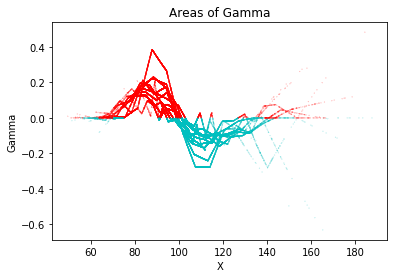

In [8]:
plt.title("Areas of Gamma")
plt.ylabel("Gamma")
plt.xlabel("X")
ts = np.linspace(0, 1, 13)
mean, paths, Gamma_t = Schema1(12, 0.20, return_params=True)
for i in range(1,len(ts)-1):
    color = np.where(Gamma_t[i]>=0, 'r','c')
    plt.scatter(paths[i],Gamma_t[i], s=0.01, color=color)

We can see when the underlying asset price X is approximately less than 100 (in the money), gammma is mostly positive and vice versa.

__(b)__ Scheme 2

In [9]:
def Schema2(t1_steps, vol_hat): 
    ##1. First Simulation
    ts = np.linspace(0, 1, t1_steps+1)
    n_paths = 5000
    paths, W = blackscholes_mc(X0, vol_hat, r, q, ts, n_paths, True)
    Yt = g(paths[-1])
    
    Gamma_t = np.zeros((len(ts),n_paths)) #Notice Gamma_t only valid for i from 1 to N-1 (no including 0 and N)

    for i in range(len(ts)-2,0,-1):  #regression from N-1 to 1 (not include the begining and end since no vol change)
        dX = paths[i+1]-paths[i]
        dW = W[i+1]-W[i]
        dt = ts[i+1]-ts[i]
        ##parametric regression for estimating conditional expr to Gamma_t
        xknots = np.linspace(np.percentile(paths[i], 1), np.percentile(paths[i], 99), 15)
        ps1, fs1 = pwlinear_fit(paths[i], Yt*(dW**2-dt*(1+vol_hat*dW)), xknots)
        coeff = (dt*vol_hat*paths[i])**2
        Gamma_t[i] = 1/coeff*sum([f(paths[i])*p for (f, p) in zip(fs1, ps1)])
        ##parametric regression for estimating Yt
        ps2, fs2 = pwlinear_fit(paths[i], Yt, xknots)
        Y_1 = sum([f(paths[i])*p for (f, p) in zip(fs2, ps2)])
        sigma_diff = (Sigma(Gamma_t[i])**2 - vol_hat**2)
        Y_2 = 1/2*Gamma_t[i]*(paths[i]**2)*dt*sigma_diff
        Yt = Y_1 + Y_2
    
    #print("First simulation of Schema 2: ", np.mean(Yt)) 

    ###2. Second Simulation
    new_ts = np.linspace(0, 1, 401) 
    n_paths = 50000
    Gamma_func = [0 for i in range(len(new_ts)-1)]  #Gamma interpolation func to estimate gamma for x on given t

    #### We need to interpolation to get Gamma_t for new_ts (only interpolate on x for each constant t)
    for i in range(len(new_ts)-1):  #only interpolate from 0 to n-1 (n term has no Gamma_t in 1st simulation)
        j = int(new_ts[i]//(1/t1_steps))  #find the most close index in ts to current new_ts[i]
        j = max(j, 1)  #j starts from 1, since 0 has no Gamma_t[0] (no regression at 1st simulation)
        Gamma_func[i] = interp1d(paths[j], Gamma_t[j], kind='linear', fill_value='extrapolate')  #not using the last Gamma_t as it is 0

    new_paths = local_vol_mc(X0, Gamma_func, r, q, new_ts, n_paths)  #using new local_vol_mc to simulate paths
    Yt = g(new_paths[-1])

    #print("Second simulation of Schema 2: ", np.mean(Yt)) 
    return np.mean(Yt)

In [10]:
t1_steps = 12
vol_hat = 0.20
mean = Schema2(t1_steps, vol_hat)
print(f"delta_t1 = 1/{t1_steps}, vol_hat = {vol_hat}, price = {mean}")

delta_t1 = 1/12, vol_hat = 0.2, price = 54.58684591900607


Comparing to schema 1, we can see that schema 2 estimates lower prices.

__(3)__ Schema 2a

In [11]:
def Schema2a(t1_steps, vol_hat): 
    ##1. First Simulation
    ts = np.linspace(0, 1, t1_steps+1)
    n_paths = 5000
    paths,W = blackscholes_mc(X0, vol_hat, r, q, ts, n_paths, True)
    Yt = g(paths[-1])
    
    Gamma_t = np.zeros((len(ts),n_paths)) #Notice Gamma_t only valid for i from 1 to N-1 (no including 0 and N)

    for i in range(len(ts)-2,0,-1):  #regression from N-1 to 1 (not include the begining and end since no vol change)
        dX = paths[i+1]-paths[i]
        dW = W[i+1]-W[i]
        dt = ts[i+1]-ts[i]
        ##parametric regression for estimating Yt
        xknots = np.linspace(np.percentile(paths[i], 1), np.percentile(paths[i], 99), 15)
        ps1, fs1 = pwlinear_fit(paths[i], Yt, xknots)
        Y_1 = sum([f(paths[i])*p for (f, p) in zip(fs1, ps1)])
        ##parametric regression for estimating conditional expr to Gamma_t
        ps2, fs2 = pwlinear_fit(paths[i], (Yt-Y_1)*(dW**2-dt*(1+vol_hat*dW)), xknots)  ##use Y_1(cond_Y) to estimate Gamma_t
        coeff = (dt*vol_hat*paths[i])**2
        Gamma_t[i] = 1/coeff*sum([f(paths[i])*p for (f, p) in zip(fs2, ps2)])
        ##after using Y_1 (cond_Y) in Gamma_t, use Gamma_t to return to estimate Yt
        sigma_diff = (Sigma(Gamma_t[i])**2 - vol_hat**2)
        Y_2 = 1/2*Gamma_t[i]*(paths[i]**2)*dt*sigma_diff
        Yt = Y_1 + Y_2
    
    #print("First simulation of Schema 2a: ", np.mean(Yt)) 

    ###2. Second Simulation
    new_ts = np.linspace(0, 1, 401)
    n_paths = 50000
    Gamma_func = [0 for i in range(len(new_ts)-1)]  #Gamma interpolation func to estimate gamma for x on given t

    #### We need to interpolation to get Gamma_t for new_ts (only interpolate on x for each constant t)
    for i in range(len(new_ts)-1):  #only interpolate from 0 to n-1 (n term has no Gamma_t in 1st simulation)
        j = int(new_ts[i]//(1/t1_steps))  #find the most close index in ts to current new_ts[i]
        j = max(j, 1)  #j starts from 1, since 0 has no Gamma_t[0] (no regression at 1st simulation)
        Gamma_func[i] = interp1d(paths[j], Gamma_t[j], kind='linear', fill_value='extrapolate')  #not using the last Gamma_t as it is 0

    new_paths = local_vol_mc(X0, Gamma_func, r, q, new_ts, n_paths)  #using new local_vol_mc to simulate paths
    Yt = g(new_paths[-1])

    #print("Second simulation of Schema 2a: ", np.mean(Yt)) 
    return np.mean(Yt)

In [12]:
t1_steps = 12
vol_hat = 0.20
mean2, mean2a = [0 for i in range(20)], [0 for i in range(20)]
for i in range(20):
    mean2[i] = Schema2(t1_steps, vol_hat)
    mean2a[i] = Schema2a(t1_steps, vol_hat)
print(f"Schema 2, price = {np.mean(mean2)}, variance = {np.var(mean2)}")
print(f"Schema 2a, price = {np.mean(mean2a)}, variance = {np.var(mean2a)}")

Schema 2, price = 53.58294997168586, variance = 0.4141347007224095
Schema 2a, price = 54.93837661773982, variance = 0.1135384736816611


Comparing to schema 2, we can see the price estimated from schema 2a is closer to the true price and has a much lower variance.

__Explanation__: 


We can derive that $\Gamma_{t_{i-1}}^{s_{2}}$ in schema 2 is the same as $\Gamma_{t_{i-1}}^{s_{2a}}$ in schema 2a.

\begin{align*}
\Gamma_{t_{i-1}}^{s_{2a}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[\left(Y_{t_i}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]\right)\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]  \\
&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[Y_{t_i}\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right] - \mathbb{E}_{i-1}\left[Y_{t_i}\right]\mathbb{E}_{i-1}(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)  \\
&= \Gamma_{t_{i-1}}^{s_2} - \mathbb{E}_{i-1}\left[Y_{t_i}\right](\Delta t_i - \Delta t_i(1+\hat{\sigma}\mathbb{E}_{i-1} \left[\Delta W_{t_i}\right])) \\
& = \Gamma_{t_{i-1}}^{s_2}
\end{align*}

Thus, the replacement in schema 2a does not change the left hand side of schema 2.

<h3 style="color:deepskyblue">The particle Method and Smile Calibration</h3>

<b style="color:darkorange">Question 2.</b> Consider the stochastic local volatility (SLV) model

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
a_t=\sigma_0 e^{Y_t}\quad\text{where}\quad d Y_t = -\kappa Y_tdt+\gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $S_0 = 100$.
- $\sigma_0 = 15\%$.
- $Y_0 = 0$.
- $\rho = -50\%$.
- $\gamma = 50\%$.
- $\kappa = 1$.

The goal is to find a leverage function $l(t, S)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 15\%$. In that case, we also have $\sigma_{\textrm{Dup}}(t,S) \equiv 15\%$.

Note that the above SLV model becomes a pure stochastic volatility model when the leverage function is identically equal to 1. Below we describe a Monte Carlo simulation scheme for the pure stochastic volatility model. You can modify it to simulate and calibrate the SLV model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

The Ornstein-Uhlenbeck process $Y$ is explicitly solvable:
\begin{equation}
Y_{t_i}=e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\int_{t_{i-1}}^{t_i}\gamma e^{\kappa\left(s-t_i\right)}dW_s^{(2)}.
\end{equation}

Therefore for given $Y_{t_{i-1}}$, $Y_{t_i}$ is a Gaussian variable with 
\begin{equation}\tag{1}
\mathbb{E}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=e^{-\kappa\Delta t_i}Y_{t_{i-1}},\quad
\text{var}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=\frac{\gamma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t_i}\right)
\end{equation}

so that paths of $Y$ can be simulated exactly.

To simualte the spot process $S$, we use the Euler scheme:
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i+\sigma_0 e^{Y_{t_{i-1}}}\int_{t_{i-1}}^{t_i}dW^{(1)}_t$$

Thus for given $S_{t_{i-1}}$ and $Y_{t_{i-1}}$, $\log S_{t_i}$ and $Y_{t_i}$ are jointly Gaussian variables with

\begin{equation}\tag{2}
\mathbb{E}\left[\left.\log S_{t_i}\right\vert S_{t_{i-1}},Y_{t_{i-1}}\right]=\log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i,\quad\text{Var}\left[\left.\log S_{t_i}\right\vert S_{i_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i
\end{equation}

\begin{equation}\tag{3}
\text{Cov}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0 e^{Y_{t_{i-1}}}\frac{\gamma\rho}{\kappa}\left(1-e^{-\kappa\Delta t_i}\right)
\end{equation}

Over the time interval $[t_{i-1}, t_i]$, we can advance $\log S$ and $Y$ by generating Gaussian variables $\log S_{t_i}$ and $Y_{t_i}$ using equations (1)-(3).

<b>(a).</b> Implementation of the Particle Method.
- Implement the particle method studied in class to find the leverage function $l$. For this purpose, you may use the zero-th order non-parametric regression routine provided in the first assignment. We suggest that you use the quartic kernel

$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere}$$

together with the bandwidth 

$$h = \kappa \sigma_{\mathrm{Market}} S_0 \sqrt{\max(t_k,0.15)}N^{-0.2}$$

at discretization date $t_k$. Make sure to fine-tune the dimensionless bandwidth parameter $\kappa$. Its order of magnitude is 1.0. Use $\Delta t = 1/100$, $N=10,000$ paths. Note: In class, we described an acceleration technique that involves sorting the "particles" $(S_{t_k},a_{t_k})$ according to the spot value $S_{t_k}$. Since the kernel we have chosen has compact support and is fairly inexpensive to evaluate, you may ignore this acceleration technique here. This means that each estimation of a conditional expectation $\mathbb{E}\left[\left.a_{t_k}^2\right\vert S_{t_k}=x\right]$ (for $x$ in a grid of spot values) involves the ratio of two sums of $N$ terms each.

- Check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 15\%$. To this end, compute estimates of the call prices (maturity $T=1$) in the calibrated model for strikes $70, 80, 90, 100, 110, 120, 130, 140$, and invert the Black-Scholes formula to get the corresponding estimation of the implied volatilities $\hat\sigma(T,K)$. To estimate the call prices in the calibrated model, simulate a new set of independent paths with the calibrated leverage function $l$ and $N_2 = 100,000$ paths. For the inversion of the Black-Scholes formula, you can use the function <code>blackscholes_impv</code> provided below.

<b>(b).</b> Fix the spot-vol correlation $\rho = 0\%$ and mean reversion $\kappa=1$. We study the impact of volatility of volatility $\gamma$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\gamma$. Suggested values of $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\gamma$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the smile on $\gamma$.

<b>(c).</b> Fix the volatility of volatility $\gamma = 50\%$ and mean reversion $\kappa=1$. We study the impact of spot-vol correlation $\rho$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\rho$. Suggested values of $\rho$: $-50\%$, $0\%$, $50\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\rho$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\rho$ in the same graph. Comment on the dependence of the shape of the leverage function on $\rho$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\rho$ in the same graph. Comment on the dependence of the shape of the smile on $\rho$.

<b>(d).</b> Fix the spot-vol correlation $\rho = 0\%$ and volatility of volatility $\gamma = 50\%$. We study the impact of mean reversion $\kappa$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\kappa$. Suggested values of $\kappa$: $0.1$, $1$, $10$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\kappa$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\kappa$ in the same graph. Comment on the dependence of the shape of the smile on $\kappa$.

<b>(e).</b> Consider the forward-starting straddle with payoff
\begin{equation*}
\left\vert \frac{S_{T_2}}{S_{T_1}}-1 \right\vert
\end{equation*}
with $T_1 = T - \frac{3}{12}$, $T_2 = T$. Use $\gamma = 100\%$, $\rho = -50\%$ and $\kappa=1$. Compare the prices of this option in the Black-Scholes model with volatility 15% and in the calibrated SLV model. Comment on the result. Why is it of interest to use stochastic local volatility models for pricing derivatives?

In [13]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option.
    S: scalar or array_like
        The spot price of the underlying security.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    w = vol**2*T
    d1 = (np.log(F/K)+0.5*w)/np.sqrt(w)
    d2 = d1 - np.sqrt(w)
    callput = callput.lower()
    if callput == 'call':
        opttype = 1
    elif callput == 'put':
        opttype = -1
    else:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = (opttype*F*norm.cdf(opttype*d1)-opttype*K*norm.cdf(opttype*(d2)))*np.exp(-r*T)
    return price

In [14]:
# all inputs must be scalar
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The spot price of the underlying security.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0):
        print("here is the reason0")
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1/np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

# Example
blackscholes_impv(K=95, T=0.25, S=100, value=7, callput='call')

array(0.20654803)

In [15]:
def quartic_kernel(x):
    x = np.clip(x, -1, 1)  #clip array to all between min(-1) and max(1)
    return (x+1)**2*(1-x)**2

In [16]:
def kern_reg(x, xdata, ydata, bandwidth, kern=quartic_kernel): #i.e. x is xknots, and xdata is the whole sample data
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional (size K)
        The x-coordinates of the target points
    xdata: array_like (size N)
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth) 
    #xdata[:,newaxis] add into N*1, xdata[:,np.newaxis]-x use braodcasting to turn N*1 into N*K, 
    #then minus K size array to each row, get N*K final weights
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


__Question 2 Answers__

__(a)__ Implementation of Partical Method

For the stochastic local volatility (SLV) model with leverage function not equal to 1,

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
a_t=\sigma_0 e^{Y_t}\quad\text{where}\quad d Y_t = -\kappa Y_tdt+\gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

We can derive its Monte Carlo simulation scheme following the pure stochastic volatility model above.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

To simulate the Ornstein-Uhlenbeck process $Y$, we use the same formula:
\begin{equation}\tag{1}
Y_{t_i}=e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\int_{t_{i-1}}^{t_i}\gamma e^{\kappa\left(s-t_i\right)}dW_s^{(2)}, \quad
\mathbb{E}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=e^{-\kappa\Delta t_i}Y_{t_{i-1}},\quad
\text{var}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=\frac{\gamma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t_i}\right)
\end{equation}


To simulate the spot process $S$, we use the following Euler scheme, with $\log S_{t_i}$ and $Y_{t_i}$ are jointly Gaussian variables:
$$\log S_{t_i} = \log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\int_{t_{i-1}}^{t_i} dW^{(1)}_t$$

\begin{equation}\tag{3}
\mathbb{E}\left[\left.\log S_{t_i}\right\vert S_{t_{i-1}},Y_{t_{i-1}}\right]=\log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i,\quad\text{Var}\left[\left.\log S_{t_i}\right\vert S_{i_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i
\end{equation}

\begin{equation}\tag{4}
\text{Cov}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\frac{\gamma\rho}{\kappa}\left(1-e^{-\kappa\Delta t_i}\right)
\end{equation}

Over the time interval $[t_{i-1}, t_i]$, we can advance $\log S$ and $Y$ by generating Gaussian variables $\log S_{t_i}$ and $Y_{t_i}$ using equations (1),(3),(4).

We can re-write the nonlinear SDE and derive the leverage function as follows:


\begin{equation}\tag{5}
\frac{dS_t}{S_t} = \frac{\sigma_{loc}(t,S_t)}{\sqrt{\mathbb{E}[a_t^2|S_t]}} a_t dW_t, \quad
l(t,S_{t}) = \frac{\sigma_{loc}(t,S_t)}{\sqrt{\mathbb{E}[a_t^2|S_t]}}
\end{equation}

where we can use kernel regression with kernel $\delta_{t,N}$ to estimate $\mathbb{E}[a_t^2|S_t]$ by
\begin{equation}\tag{6}
\mathbb{E}[a_t^2|S_t] = \bar{a}(t,S)^2 = \frac{\sum_{i=1}^N(a_t^{i,N})^2\delta_{t,N}(S_t^{i,N}-S)}{\sum_{i=1}^N \delta_{t,N}(S_t^{i,N}-S)}
\end{equation}


In [17]:
##func for simulate W1, W2
def simulate_dW(n_steps, n_paths, rho):
    ts = np.linspace(0, 1, n_steps+1)
    ##notice we simulate all W1, W2 with standard normal(0,1), without dt term (will add dt variance in the SLV_model)
    W1 = np.cumsum(np.vstack((np.zeros((1, n_paths), dtype=np.float), 
                        np.random.randn(n_steps, n_paths))), axis=0)
    Z = np.cumsum(np.vstack((np.zeros((1, n_paths), dtype=np.float), 
                        np.random.randn(n_steps, n_paths))), axis=0)
    #in this way, W1 and W2 has correlation rho
    W2 = rho*W1+np.sqrt(1-rho**2)*Z  
    return W1, W2


##Stochastic Local Volatility Model (with varying leverage func)
def SLV_model(rho=0, kappa=1, gamma=0.5, vol_mkt=0.15, n_steps=100, n_paths=10000, return_params=False):
    ##1. Simulate W1, W2
    W1,W2 = simulate_dW(n_steps, n_paths, rho)
    ts = np.linspace(0, 1, n_steps+1)
    ##2. Simulate Yt and St in discretization schema with kernel regression (partical method)
    Y0, S0 = 0, 100
    bw_kappa = 3.5
    paths = np.zeros((n_steps+1, n_paths))
    paths[0] = S0
    Yt = Y0
    St = S0
    log_St = np.log(St)
    leverg_func = [0 for i in range(len(ts)-1)]  #leverage func, there is no func for t=N (end)
    alpha = vol_mkt
    leverg_func[0] = np.vectorize(lambda x: vol_mkt/alpha)  #initialize leverg_func[0] to constant value func
    leverg_value = vol_mkt/alpha
    for i in range(1,len(ts)):
        dt = ts[i]-ts[i-1]
        dW1 = W1[i]-W1[i-1]
        dW2 = W2[i]-W2[i-1]
        #update St, Yt (must update log_St before Yt as using Y_{t-1})
        #notice the variance used below for log_St, Yt already include dt term, and dW is pure stand normal(0,1)
        log_St = log_St-1/2*vol0**2*np.exp(2*Yt)*leverg_value**2*dt + vol0*np.exp(Yt)*leverg_value*np.sqrt(dt)*dW1
        St = np.exp(log_St)
        Yt = np.exp(-kappa*dt)*Yt + gamma*np.sqrt((1-np.exp(-2*kappa*dt))/(2*kappa))*dW2
        paths[i] = St #save updated Yt of curr step to paths
        
        bandw = bw_kappa*vol_mkt*S0*np.sqrt(max(ts[i-1], 0.15))*n_paths**(-0.2)
        at_2 = vol0**2*np.exp(2*Yt)  #at^2
        ##pair_data = np.array(sorted(zip(St,Yt), key=lambda pair: pair[0]))  #particle method to sort and pick data
        S_grid = np.linspace(np.percentile(St,1),np.percentile(St,99),8) 
        #here we use all data (St) and ignore particle method which uses only S closer to each S_grid for regression
        #estimate E[a_t^2|St=S] by kernel regression
        cond_at_2 = kern_reg(S_grid, St, at_2, bandw, kern=quartic_kernel)   #x=S_grid, xdata=St, ydata=at_2
        if i<len(ts)-1: #no leverg func for maturity 
            l = vol_mkt/(cond_at_2**0.5)  #leverage func l(t,St) value
            f = interp1d(S_grid, l, kind='cubic', fill_value="extrapolate") #func used for next turn
            #as we use fill_value(y_min, y_max) in interp1d, we must clip x_new (St_new) to [x_min,x_max] as well
            #St_new = np.clip(St, S_grid[0], S_grid[-1])  #clip St to [S_grid[0], S_grid[-1]], flat on two ends
            leverg_value = f(St)  #used for next round
            leverg_func[i] = f
    if return_params:
        return paths, leverg_func
    else:
        return paths
    
#monte calro simulation under stochastic local volatility model (with given leverg_func)
#when leverg_func = 1, this is pure stoch vol model
def SLV_model_mc(leverg_func, rho=0, kappa=1, gamma=0.5, vol_mkt=0.15, n_steps=100, n_paths=10000):
    W1,W2 = simulate_dW(n_steps, n_paths, rho)
    ts = np.linspace(0, 1, n_steps+1)
    Y0, S0 = 0, 100
    paths = np.zeros((n_steps+1, n_paths))
    paths[0] = S0
    Yt, St = Y0, S0
    log_St = np.log(St)
    for i in range(1,len(ts)):
        dt = ts[i]-ts[i-1]
        dW1 = W1[i]-W1[i-1]
        dW2 = W2[i]-W2[i-1]
        leverg_value = leverg_func[i-1](St)  #use last round leverg_func to update this round
        #update St, Yt (must update log_St before Yt as using Y_{t-1})
        #notice the variance used below for log_St, Yt already include dt term, and dW is pure stand normal(0,1)
        log_St = log_St-1/2*vol0**2*np.exp(2*Yt)*leverg_value**2*dt + vol0*np.exp(Yt)*leverg_value*np.sqrt(dt)*dW1
        St = np.exp(log_St)
        Yt = np.exp(-kappa*dt)*Yt + gamma*np.sqrt((1-np.exp(-2*kappa*dt))/(2*kappa))*dW2
        paths[i] = St #save updated Yt of curr step to paths
    
    return paths

In [18]:
##calculate the call price and implied volatility of the paths simulated from step 2
Y0, S0 = 0, 100
rho = -0.5
vol0, vol_mkt = 0.15, 0.15  #vol_mkt is the local vol (flat every where) for all t
gamma = 0.5
kappa = 1
n_steps, n_paths = 100, 10000
paths_2a, leverg_func_2a = SLV_model(rho, kappa, gamma, vol_mkt, n_steps, n_paths, True)

##Resimulate N2=100000 paths to calibrate 
n_steps, n_paths = 100, 100000
strike = [70,80,90,100,110,120,130,140]
paths_2a_new = SLV_model_mc(leverg_func_2a, rho, kappa, gamma, vol_mkt, n_steps, n_paths)
S_T = paths_2a_new[-1]  #maturity price
for K in strike:
    price = np.mean(np.maximum(S_T-K,0))
    imp_vol = blackscholes_impv(K, T=1, S=S0, value=price, callput="call")  #get the implied vol
    print(f"call option, strike K={K}, price = {price}, implied_vol = {imp_vol}")

call option, strike K=70, price = 30.041699423866394, implied_vol = 0.15256078019394428
call option, strike K=80, price = 20.411271471964305, implied_vol = 0.15064888525995498
call option, strike K=90, price = 12.023772482727438, implied_vol = 0.15006933949775633
call option, strike K=100, price = 5.975988494067491, implied_vol = 0.14993614444284936
call option, strike K=110, price = 2.483953408471344, implied_vol = 0.14952189896299073
call option, strike K=120, price = 0.8703642730535127, implied_vol = 0.14899055508023737
call option, strike K=130, price = 0.2674637058657802, implied_vol = 0.1490564312370771
call option, strike K=140, price = 0.07521147495650185, implied_vol = 0.14966406698226248


We can see that the model is indeed calibrated to the market implied volatility. And with the strike price of the call option increasing, its price decreases and implied volatility also decreases. In fact, the volatility smirk (skew) appears, which is because that deep in the money (ITM) options have higher sensitivity to volatility change than at the money (ATM) options. For deep ITM options, the potential jumps or flunctuations could lead to very high prices. In order to account for this high price, we need a relatively higher implied volatility.

<b>(b).</b> Fix the spot-vol correlation $\rho = 0\%$ and mean reversion $\kappa=1$. We study the impact of volatility of volatility $\gamma$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Suggested values of $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.

Text(0, 0.5, 'L(t,S)')

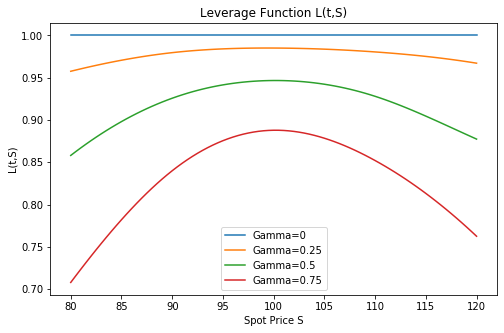

In [19]:
rho = 0
kappa = 1
n_steps, n_paths = 100, 100000
gamma_list = [0, 0.25, 0.5, 0.75]
paths_2b = [0 for i in range(len(gamma_list))]
paths_2b_pure = [0 for i in range(len(gamma_list))]
leverg_func_2b = [0 for i in range(len(gamma_list))]
for i,gamma in enumerate(gamma_list):
    paths_2b[i], leverg_func_2b[i] = SLV_model(rho, kappa, gamma, vol_mkt, n_steps, n_paths, True)
    
S = np.linspace(80,120,81)
plt.figure(figsize=(8,5))
for i,gamma in enumerate(gamma_list):
    plt.plot(S,leverg_func_2b[i][-1](S),label=f"Gamma={gamma}")
plt.legend()
plt.title("Leverage Function L(t,S)")
plt.xlabel("Spot Price S")
plt.ylabel("L(t,S)")

We can see than when gamma is very small, the leverage function is relative flat. In fact, it is purely constant when gamma is zero. While when gamma is large, the leverage function is concave with deep convexity, showing relatively the highest value at the money. This is due to the fact that gamma is the volatility of volatility. When vol of vol is large, the leverage function should change more and faster to help calibrate the volatility smile, thus showing deeper convexity.

Text(0, 0.5, 'Implied Volatility')

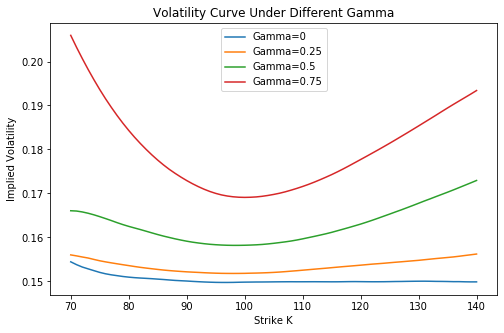

In [20]:
rho = 0
kappa = 1
n_steps, n_paths = 100, 100000
pure_leverg_func = [lambda x:1 for i in range(n_steps)]  #pure vol model, lverg=1
for i,gamma in enumerate(gamma_list):
    paths_2b_pure[i] = SLV_model_mc(pure_leverg_func, rho, kappa, gamma, vol_mkt, n_steps, n_paths)
    
strike = np.linspace(70,140,71)
implied_vol = np.zeros((len(gamma_list),len(strike)))
plt.figure(figsize=(8,5))
for i,gamma in enumerate(gamma_list):
    S_T = paths_2b_pure[i][-1]
    for j,K in enumerate(strike):
        price = np.mean(np.maximum(S_T-K,0))
        implied_vol[i,j] = blackscholes_impv(K, T=1, S=S0, value=price, callput="call")
    plt.plot(strike, implied_vol[i], label=f"Gamma={gamma}")
plt.legend()
plt.title("Volatility Curve Under Different Gamma")
plt.xlabel("Strike K")
plt.ylabel("Implied Volatility")

We can see that when gamma is large, volatility smile appears with deep convexity, where the deep out of money (OTM) and deep in the money (ITM) option have much higher volatility than in the money (ITM) ones. When gamma is decreasing, first the convexity of volatility smile decreases then the volatility smile turns to volatility smirk, where the deep ITM options have slightly higher volatility. When gamma is close to 0, the volatility is almost flat with slight skew.

<b>(c).</b> Fix the volatility of volatility $\gamma = 50\%$ and mean reversion $\kappa=1$. We study the impact of spot-vol correlation $\rho$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model.  Suggested values of $\rho$: $-50\%$, $0\%$, $50\%$.


Text(0, 0.5, 'L(t,S)')

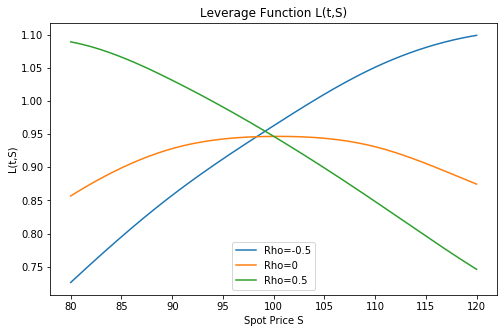

In [21]:
kappa = 1
gamma = 0.5
n_steps, n_paths = 100, 100000
rho_list = [-0.5, 0, 0.5]
paths_2c = [0 for i in range(len(rho_list))]
paths_2c_pure = [0 for i in range(len(rho_list))]
leverg_func_2c = [0 for i in range(len(rho_list))]
for i, rho in enumerate(rho_list):
    paths_2c[i], leverg_func_2c[i] = SLV_model(rho, kappa, gamma, vol_mkt, n_steps, n_paths, True)

S = np.linspace(80,120,141)
plt.figure(figsize=(8,5))
for i, rho in enumerate(rho_list):
    plt.plot(S,leverg_func_2c[i][-1](S),label=f"Rho={rho}")
plt.legend()
plt.title("Leverage Function L(t,S)")
plt.xlabel("Spot Price S")
plt.ylabel("L(t,S)")

We can see that the leverage function has negative slope with respect to S when rho is positive and positive slope when rho is negative. While when rho is zero, the leverage function is slightly concave and has relatively the highest value at the money.

Text(0, 0.5, 'Implied Volatility')

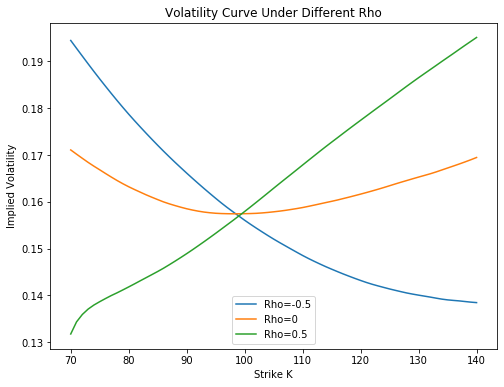

In [28]:
kappa = 1
gamma = 0.5
n_steps, n_paths = 100, 100000
for i, rho in enumerate(rho_list):
    paths_2c_pure[i] = SLV_model_mc(pure_leverg_func, rho, kappa, gamma, vol_mkt, n_steps, n_paths)

strike = np.linspace(70,140,71)
implied_vol = np.zeros((len(rho_list),len(strike)))
plt.figure(figsize=(8,6))
for i, rho in enumerate(rho_list):
    S_T = paths_2c_pure[i][-1]
    for j,K in enumerate(strike):
        price = np.mean(np.maximum(S_T-K,0))
        implied_vol[i,j] = blackscholes_impv(K, T=1, S=S0, value=price, callput="call")
    plt.plot(strike, implied_vol[i], label=f"Rho={rho}")
plt.legend()
plt.title("Volatility Curve Under Different Rho")
plt.xlabel("Strike K")
plt.ylabel("Implied Volatility")

We can see that when rho is positive, volatility smirk appears where the deep OTM option has higher volatility. When rho is negative, volatility smirk appears where the deep ITM option has higher volatility. While when rho is zero, volatility smile appears where both the deep ITM and OTM option have slightly higher volatility. In the financial market, the volatility smile is very common, especially in the forex options.

<b>(d).</b> Fix the spot-vol correlation $\rho = 0\%$ and volatility of volatility $\gamma = 50\%$. We study the impact of mean reversion $\kappa$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Suggested values of $\kappa$: $0.1$, $1$, $10$.

Text(0, 0.5, 'L(t,S)')

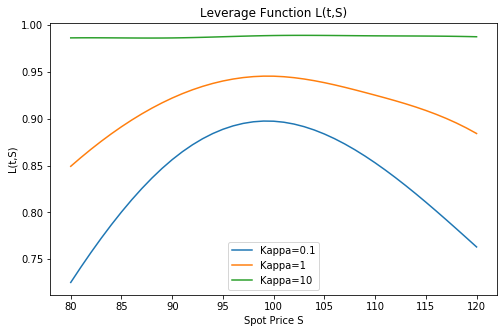

In [23]:
rho = 0
gamma = 0.5
n_steps, n_paths = 100, 100000
kappa_list = [0.1, 1, 10]
paths_2d = [0 for i in range(len(kappa_list))]
paths_2d_pure = [0 for i in range(len(kappa_list))]
ST_2d = [0 for i in range(len(kappa_list))]
leverg_func_2d = [0 for i in range(len(kappa_list))]
for i,kappa in enumerate(kappa_list):
    paths_2d[i], leverg_func_2d[i] = SLV_model(rho, kappa, gamma, vol_mkt, n_steps, n_paths, True)
    
S = np.linspace(80,120,41)
plt.figure(figsize=(8,5))
for i, kappa in enumerate(kappa_list):
    plt.plot(S,leverg_func_2d[i][-1](S),label=f"Kappa={kappa}")
plt.legend()
plt.title("Leverage Function L(t,S)")
plt.xlabel("Spot Price S")
plt.ylabel("L(t,S)")

We can see than when kappa is very large, the leverage function is almost flat. While when kappa is small and close to 0, the leverage function is concave with deep convexity, showing relatively the highest value at the money.

Text(0, 0.5, 'Implied Volatility')

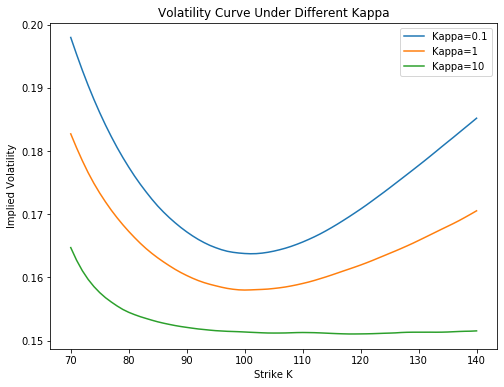

In [27]:
rho = 0
gamma = 0.5
n_steps, n_paths = 100, 100000
for i,kappa in enumerate(kappa_list):
    paths_2d_pure[i] = SLV_model_mc(pure_leverg_func, rho, kappa, gamma, vol_mkt, n_steps, n_paths) #pure vol model, lverg=1

strike = np.linspace(70,140,71)
implied_vol = np.zeros((len(kappa_list),len(strike)))
plt.figure(figsize=(8,6))
for i, kappa in enumerate(kappa_list):
    S_T = paths_2d_pure[i][-1]
    for j,K in enumerate(strike):
        price = np.mean(np.maximum(S_T-K,0))
        implied_vol[i,j] = blackscholes_impv(K, T=1, S=S0, value=price, callput="call")
    plt.plot(strike, implied_vol[i], label=f"Kappa={kappa}")
plt.legend()
plt.title("Volatility Curve Under Different Kappa")
plt.xlabel("Strike K")
plt.ylabel("Implied Volatility")

We can see that when kappa is very small, volatility smile appears with deeper convexity, where the deep ITM and OTM option both have much higher volatility than ATM option. When kappa is large, volatility smirk appears with slight skew. This is because kappa is rate of mean reversion. So when kappa is large, volatility will flunctuate around a high level more such that OTM options can have better chance of reaching above the strike and ending up in the money. Thus, both ITM and OTM options will have closer price and implied volatility will not differ much under different strike prices.

<b>(e).</b> Consider the forward-starting straddle with payoff
\begin{equation*}
\left\vert \frac{S_{T_2}}{S_{T_1}}-1 \right\vert
\end{equation*}
with $T_1 = T - \frac{3}{12}$, $T_2 = T$. Use $\gamma = 100\%$, $\rho = -50\%$ and $\kappa=1$. Compare the prices of this option in the Black-Scholes model with volatility 15% and in the calibrated SLV model. Comment on the result. Why is it of interest to use stochastic local volatility models for pricing derivatives?

In [25]:
#Use time steps of 12
T1_idx = 9
T2_idx = 12
bs_paths = blackscholes_mc(S=100, vol=0.15, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=10000)
bs_price = np.mean(np.abs(bs_paths[T2_idx]/bs_paths[T1_idx]-1))
print(f"Blackscholes price: {bs_price}")

Blackscholes price: 0.06075338951033555


In [26]:
rho = -0.5
gamma = 1
kappa = 1
n_steps, n_paths = 12, 10000
paths_2e, leverg_func_2e = SLV_model(rho, kappa, gamma, vol_mkt, n_steps, n_paths, True)
slv_price = np.mean(np.abs(paths_2e[T2_idx]/paths_2e[T1_idx]-1))
print(f"SLV model price: {slv_price}")

SLV model price: 0.053156123898633015


We can see the price from the calibrated stochastic local volatility (SLV) model is smaller than that from the Black-scholes model. This is because SLV treats volatility differently at each path and each specific time. In this way, it has better chance of covering the risk from different time and thus has lower price estimation.

To illustrate, SLV models are useful because they explain in a selfconsistent way why options with different strikes and expirations have different Black-Scholes implied volatilities – the "volatility smile". In particular, traders who use the BlackScholes model to hedge must continuously change the volatility assumption in order to match market prices. Their hedge ratios change accordingly in an uncontrolled way, which is in consistent with the SLV models. In fact, the prices of exotic options given by black-scholes based model can be wildly wrong, so dealers in such options are motivated to find models which can take the volatility smile into account when pricing these. That's way SLV models are of great interest for pricing derivatives.